In [1]:
library('igraph')
library('Matrix')
library('pracma')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Warning message:
“package ‘pracma’ was built under R version 3.5.0”
Attaching package: ‘pracma’

The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu



In [2]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

random_walk = function (g, num_steps, start_node, transition_matrix = NULL, teleport = 0,
                       teleport_type="uniform",pr = NULL, medians=NULL){
  visited_nodes = rep(0,num_steps)
  if(is.null(transition_matrix))
    transition_matrix = create_transition_matrix(g)
  
  v = start_node
  for(i in 1:num_steps){
    #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
    if (runif(1) < teleport) {
        if (teleport_type == "uniform") {
            v = sample(1:vcount(g),1)
        }
        else if (teleport_type == "pagerank") {
            v = sample(1:vcount(g),1,prob = pr)
        }
        else if (teleport_type == "median") {
            v = sample(medians,1)
        }
        else {
            print("Error with teleport_type. Exiting code")
            quit()
        }
        
    }
    else {
        PMF = transition_matrix[v, ]
        v = sample(1:vcount(g), 1, prob = PMF)
    }
    visited_nodes[i] = v
  }
  
  return(visited_nodes)
}

# function to perform a random walk on graph g
# returns the probability that each node is visited given the random walks as samples
# g: graph
# numsteps: number of steps before terminating random walk
# numiterations: number of random walks to perform
# teleportProbability: probability of teleporting
# 

evaluate_page_rank = function(g, numsteps, numiterations, teleportProbability, teleportType) {
    # Get the number of steps that need to pass before graph is in "steady state"
    steadyStateSteps = ceiling(log(vcount(g)))
    
    # Initialize the vector that stores the counts of each node after steady state
    visitedCounts = rep(0,vcount(g))
    
    # Have a vector to store the index of each node
    indexList = seq(from=1,to=vcount(g))
    
    # Get the transition matrix
    transitionMatrix = create_transition_matrix(g)
    
    # Page rank 
    pagerank = page_rank(g)
    pagerank = pagerank$vector
    sortedPagerank = order(pagerank)
    prMedians = c(sortedPagerank[floor(vcount(g)/2)], sortedPagerank[floor(vcount(g)/2)+1])

    for (i in 1:numiterations) {
        visitedNodes = random_walk(g,start=sample(indexList,1),num_steps=numsteps,transitionMatrix,
                                  teleport=teleportProbability,teleport_type=teleportType,pr=pagerank,
                                  medians=prMedians)
        for (j in 1:length(visitedNodes)) {
            if (j > steadyStateSteps) {
                visitedCounts[visitedNodes[j]] = visitedCounts[visitedNodes[j]] + 1
            }
        }
    }
    nodeProbabilities = visitedCounts / ((numsteps-steadyStateSteps) * numiterations)
    return(nodeProbabilities)
}

In [7]:
## Problem 2, Part 1

N = 1000
P = 0.01
NUM_STEPS = 200
NUM_TRIALS = 1000

erdos_graph = erdos.renyi.game(N, p.or.m=0.01, type="gnp")
erdos_transitions = create_transition_matrix(erdos_graph)

visit_matrix = matrix(0,NUM_TRIALS,NUM_STEPS)
for (i in 1:NUM_TRIALS) {
    visit_matrix[i,1:NUM_STEPS] = random_walk(erdos_graph, NUM_STEPS, sample(vcount(erdos_graph),1), erdos_transitions)
}

# Analyze the distance from the starting node of each step in the random walk

distance_matrix = matrix(0,NUM_TRIALS,NUM_STEPS)
shortest_path_matrix = shortest.paths(erdos_graph)

for (i in 1:NUM_TRIALS) {
    for (j in 2:NUM_STEPS) {
        distance_matrix[i,j] = shortest_path_matrix[visit_matrix[i,1],visit_matrix[i,j]]
    }
}


mean_distances = colSums(distance_matrix) / NUM_TRIALS
mean_matrix = matrix(mean_distances,nrow=NUM_TRIALS,ncol=length(mean_distances),byrow=TRUE)
variance_matrix = (distance_matrix - mean_matrix)^2
mean_variances = colSums(variance_matrix) / NUM_TRIALS

plot(mean_distances, main =paste("Average distance vs time with", N, "nodes"), xlab = "t", ylab = "Mean Shortest Distance")
plot(mean_variances, main = paste("Variance vs time with", N, "nodes"), xlab="t", ylab="Variance of Shortest Distance")

hist(degree(erdos_graph,visit_matrix[1:NUM_TRIALS,NUM_STEPS]), ,main="Degree distribution of the network",xlab="Degree",ylab="Frequency")
hist(degree(erdos_graph), main="Degree dist. for random walk", xlab="Degree",ylab="Frequency")


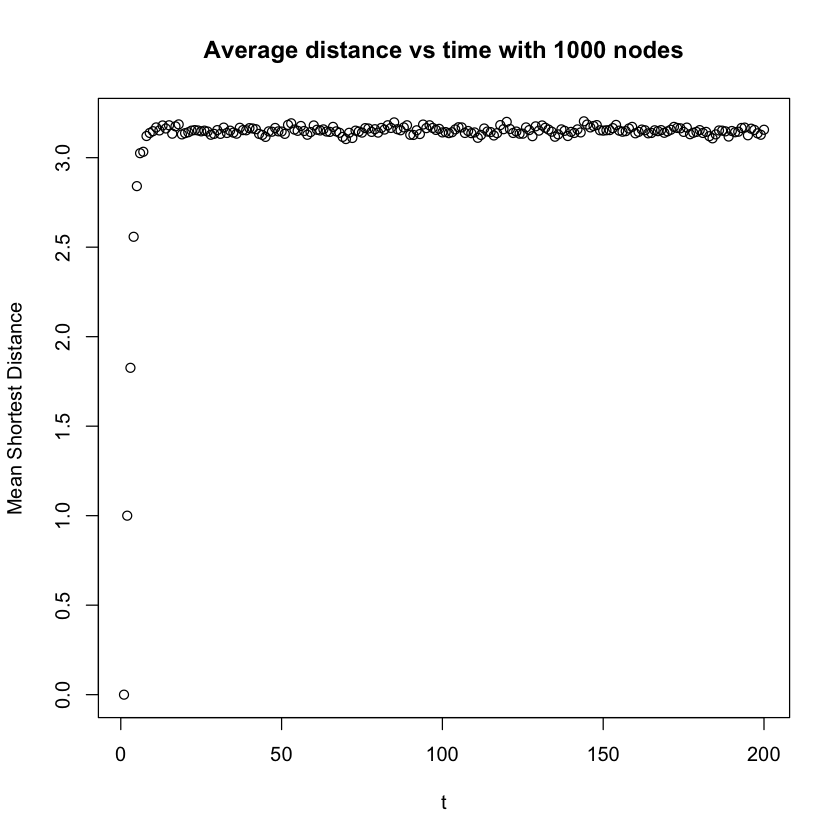

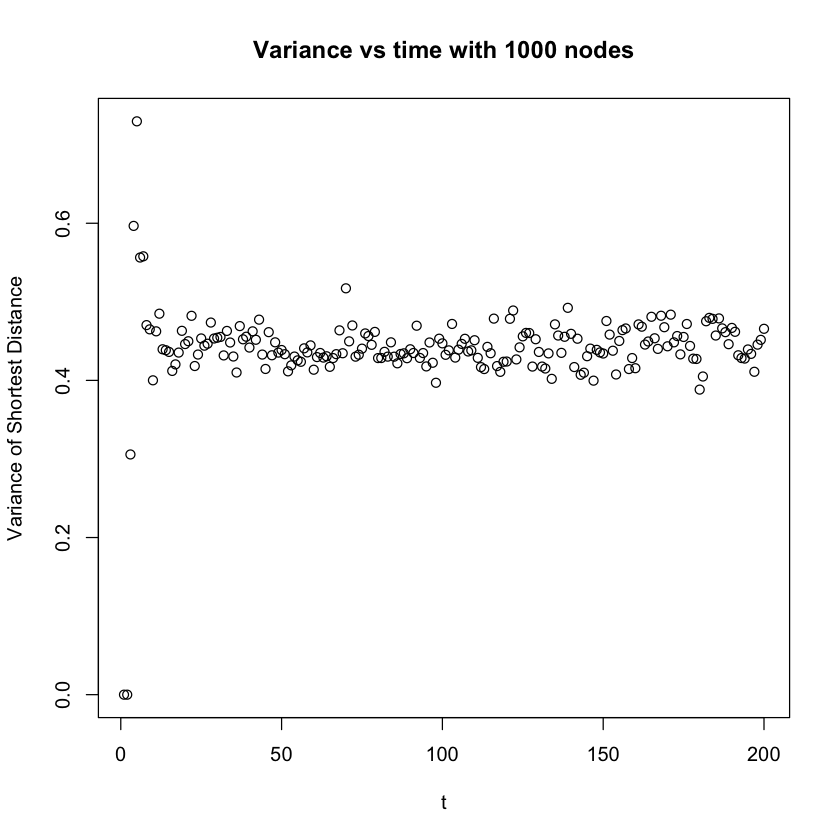

In [8]:
plot(mean_distances, main =paste("Average distance vs time with", N, "nodes"), xlab = "t", ylab = "Mean Shortest Distance")
plot(mean_variances, main = paste("Variance vs time with", N, "nodes"), xlab="t", ylab="Variance of Shortest Distance")

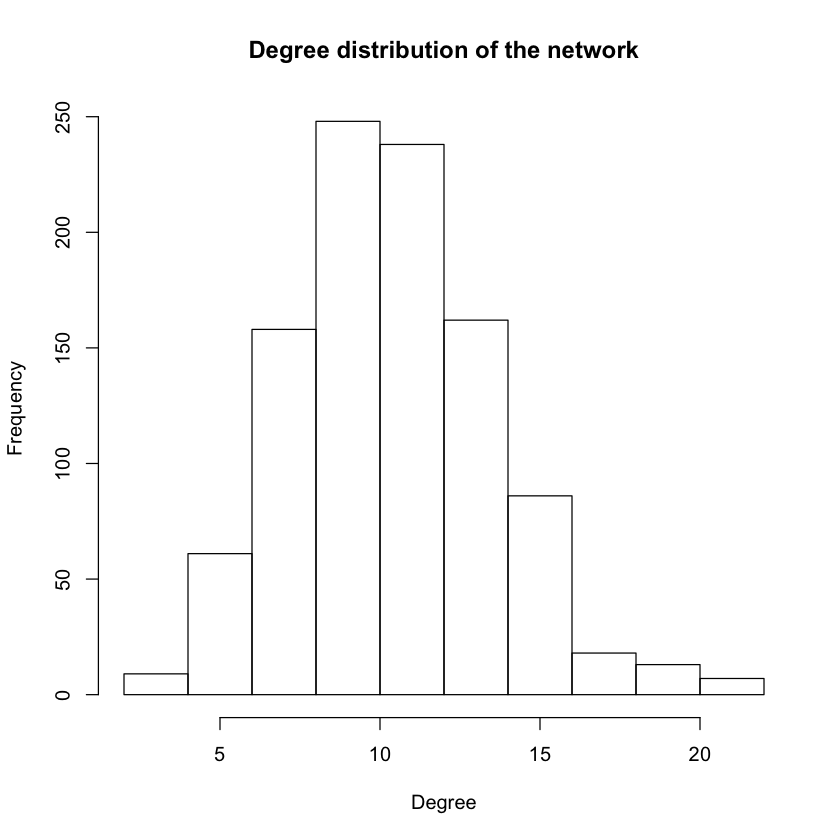

In [9]:
hist(degree(erdos_graph,visit_matrix[1:NUM_TRIALS,NUM_STEPS]), ,main="Degree distribution of the network",xlab="Degree",ylab="Frequency")
hist(degree(erdos_graph), main="Degree dist. for random walk", xlab="Degree",ylab="Frequency")

In [48]:
## Problem 2, Part 3, Part (a) (Page Rank)
N = 1000
M = 4

# Create a directed random network with 1000 nodes using the preferential attachment network
g1 = barabasi.game(n=N,m=M)

# To prevent a black hole, create another random network and shuffle the node indices
indexList = seq(from=1,to=N)

g2_raw = barabasi.game(n=N,m=M)
g2 = permute(g2_raw, sample(vcount(g2_raw)))
g2_edges = t(as_edgelist(g2))
combined_graph = add_edges(g1,g2_edges)

# g2 = barabasi.game(n=N,m=M)
# g2edgeList = as_edgelist(g2)
# shuffleDict = sample(indexList)
# for (i in 1:dim(g2edgeList)[1]) {
#     for (j in 1:2) {
#         g2edgeList[i,j] = shuffleDict[g2edgeList[i,j]]
#     }
# }
# g2 = graph_from_edgelist(g2edgeList)

# Add the edges from the second network to the first one
#combined_graph = union(g1,g2)
nodeDegrees = degree(combined_graph)
pagerank_transitions = create_transition_matrix(combined_graph)

In [61]:
NUM_STEPS = 1000
NUM_ITERATIONS = 100

probabilities_3a = evaluate_page_rank(combined_graph, NUM_STEPS, NUM_ITERATIONS, 0,    "uniform")
probabilities_3b = evaluate_page_rank(combined_graph, NUM_STEPS, NUM_ITERATIONS, 0.15, "uniform")
probabilities_4a = evaluate_page_rank(combined_graph, NUM_STEPS, NUM_ITERATIONS, 0.15, "pagerank")
probabilities_4b = evaluate_page_rank(combined_graph, NUM_STEPS, NUM_ITERATIONS, 0.15, "median")

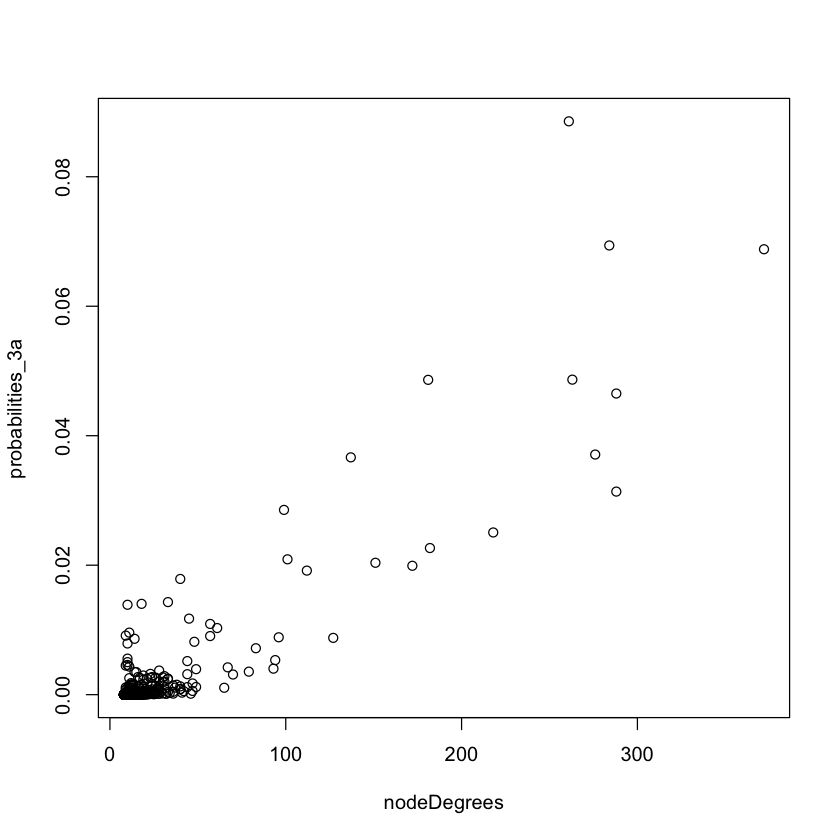

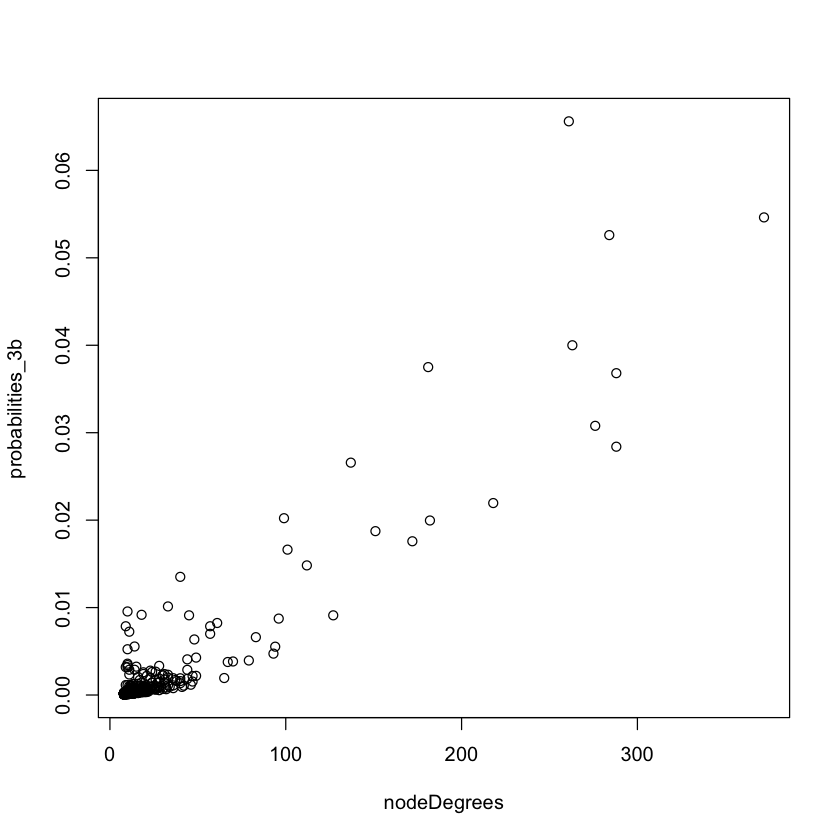

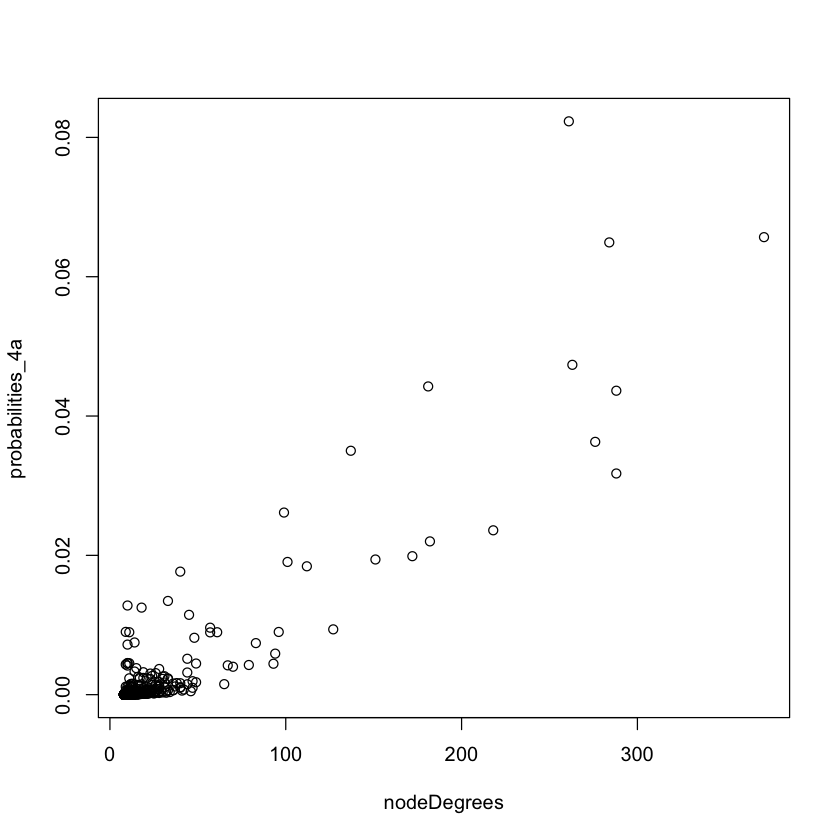

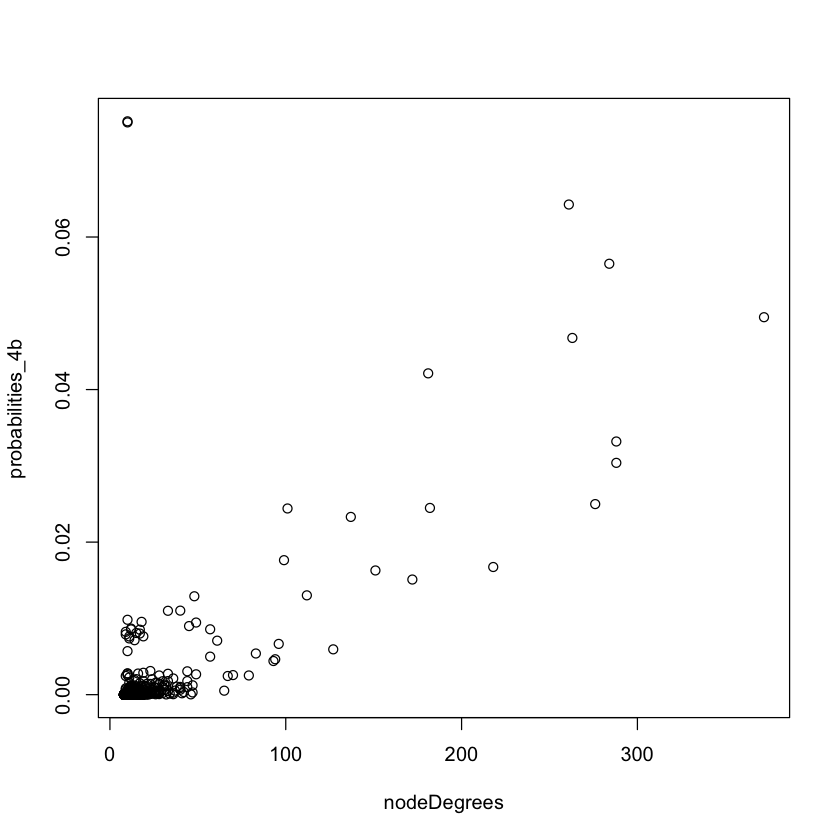

In [62]:
nodeDegrees = degree(combined_graph)
plot(nodeDegrees,probabilities_3a)
plot(nodeDegrees,probabilities_3b)
plot(nodeDegrees,probabilities_4a)
plot(nodeDegrees,probabilities_4b)

In [66]:
print(cor(nodeDegrees,probabilities_3a))
print(cor(nodeDegrees,probabilities_3b))
print(cor(nodeDegrees,probabilities_4a))
print(cor(nodeDegrees,probabilities_4b))

[1] 0.8978332
[1] 0.9252948
[1] 0.90739
[1] 0.7135287


In [72]:
fit_3a = lm(probabilities_3a ~ nodeDegrees)
fit_3a
fit_3b = lm(probabilities_3b ~ nodeDegrees)
fit_3b
fit_4a = lm(probabilities_4a ~ nodeDegrees)
fit_4a
fit_4b = lm(probabilities_4b ~ nodeDegrees)
fit_4b


Call:
lm(formula = probabilities_3a ~ nodeDegrees)

Coefficients:
(Intercept)  nodeDegrees  
 -0.0018739    0.0001801  



Call:
lm(formula = probabilities_3b ~ nodeDegrees)

Coefficients:
(Intercept)  nodeDegrees  
 -0.0013019    0.0001442  



Call:
lm(formula = probabilities_4a ~ nodeDegrees)

Coefficients:
(Intercept)  nodeDegrees  
 -0.0017426    0.0001718  



Call:
lm(formula = probabilities_4b ~ nodeDegrees)

Coefficients:
(Intercept)  nodeDegrees  
 -0.0012375    0.0001402  


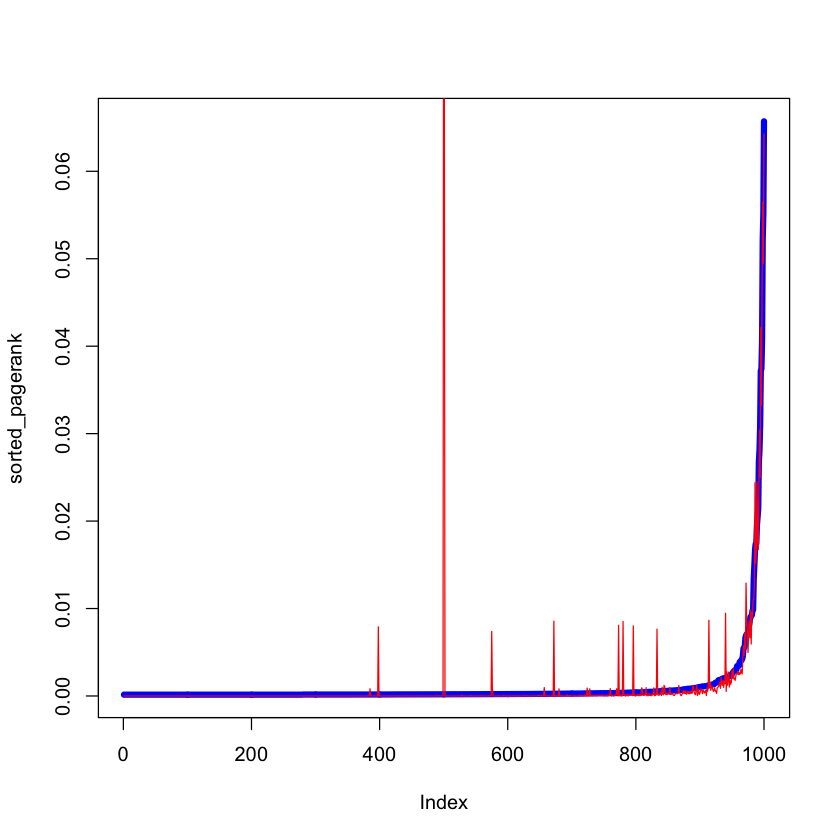

In [86]:
pagerank = page_rank(combined_graph)$vector
sorted_pagerank = sort(pagerank)
pagerank_order = order(pagerank)
corresponding_4b_probabilities = probabilities_4b[pagerank_order]

plot(sorted_pagerank,col="blue",type='l',lwd=5)
points(corresponding_4b_probabilities,col="red",type='l')

In [8]:
sample(10,1)

[1] 4